##Classification of US quarters

In [1]:
# load data from google drive
!unzip /content/drive/MyDrive/data_quarters.zip

Archive:  /content/drive/MyDrive/data_quarters.zip
   creating: images_sorted/
   creating: images_sorted/US.Quarter.2020.Vermont.Reverse/
   creating: images_sorted/US.Quarter.2021.Alabama.Reverse/
   creating: images_sorted/US.Quarter.2005.Oregon.Reverse/
   creating: images_sorted/US.Quarter.2010.Oregon.Reverse/
   creating: images_sorted/US.Quarter.Obverse/
   creating: images_sorted/US.Quarter.2001.New York.Reverse/
   creating: images_sorted/US.Quarter.2019.Northern Mariana Islands.Reverse/
   creating: images_sorted/US.Quarter.1999.Pennsylvania.Reverse/
   creating: images_sorted/US.Quarter.2018.Rhode Island.Reverse/
   creating: images_sorted/US.Quarter.2015.Louisiana.Reverse/
   creating: images_sorted/US.Quarter.2020.U.S. Virgin Islands.Reverse/
   creating: images_sorted/US.Quarter.2015.North Carolina.Reverse/
   creating: images_sorted/US.Quarter.2015.New York.Reverse/
   creating: images_sorted/US.Quarter.2018.Georgia.Reverse/
   creating: images_sorted/US.Quarter.2007.Uta

In [2]:
# find empty directories and delete them

!find images_sorted -type d -empty -exec rmdir {} \;


find: ‘images_sorted/US.Quarter.2021.Alabama.Reverse’: No such file or directory
find: ‘images_sorted/US.Quarter.2009.US Virgin Islands.Reverse’: No such file or directory


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K




from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot



import time




In [2]:
batch_size = 32
img_height = 256
img_width =  256

In [3]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2)

train_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='training')


valid_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='validation')
        





Found 1043 images belonging to 111 classes.
Found 187 images belonging to 111 classes.


In [4]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [5]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [6]:
n_classes=len(y_train[0])
n_classes

111

In [7]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])
y_valid = np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

In [8]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1)

In [9]:
def get_pairs(batch_size,test=False):

  if test:

    X = X_valid
    y = y_valid
    
  else:

    X = X_train
    y = y_train


   

  n, img_height,img_width, c = X_train.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)

    # first half of the set: images are from different classes
    if i < batch_size//2 :
      
      
      while y[idx1] == y[idx2]:  # if from same class

        idx2 = np.random.randint(0,n)  #try another random index
    
    # second half of the set: images are from the same class

    # this part was rewritten to optimize generation from large datasets

    if i >= batch_size//2 :
      
      
      y0 = y[idx1]

      # generate an array of indices of the elements from the same class as element idx1
      indices = [i for i, y in enumerate(y_train) if y == y0]
      
      # and get a random element from this array
      idx2 = indices[ np.random.randint(0,len(indices))]

     

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [10]:
def pairs_generator(batch_size, test = False):
    while True:
        pairs, targets = get_pairs(batch_size,test = test)
        yield (pairs, targets)

In [20]:
# Siamese network

input_left = Layers.Input((img_width,img_height,3))
input_right = Layers.Input((img_width,img_height,3))


resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

base_model = tf.keras.Sequential()
base_model.add(resnet_model)
base_model.add(Layers.GlobalAveragePooling2D())

encoded_left = base_model(input_left)
encoded_right = base_model(input_right)



L1_layer = Layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_left, encoded_right])


prediction = Layers.Dense(1,activation='sigmoid')(L1_distance)

model = tf.keras.models.Model(inputs=[input_left,input_right],outputs=prediction)



model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[0][0]         

In [21]:
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])


In [22]:
batch_size = 32
steps_per_epoch = X_train.shape[0]//batch_size

In [23]:
tic = time.time()

trained = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=100,
            )

toc=time.time()    
print(str(toc-tic)+ ' s')

Epoch 1/100
32/32 [==============================] - 37s 934ms/step - loss: 0.7297 - accuracy: 0.5632
Epoch 2/100
32/32 [==============================] - 30s 923ms/step - loss: 0.5140 - accuracy: 0.7359
Epoch 3/100
32/32 [==============================] - 30s 927ms/step - loss: 0.3099 - accuracy: 0.8635
Epoch 4/100
32/32 [==============================] - 29s 919ms/step - loss: 0.2797 - accuracy: 0.8867
Epoch 5/100
32/32 [==============================] - 29s 905ms/step - loss: 0.2308 - accuracy: 0.9010
Epoch 6/100
32/32 [==============================] - 29s 909ms/step - loss: 0.2386 - accuracy: 0.9015
Epoch 7/100
32/32 [==============================] - 29s 903ms/step - loss: 0.2025 - accuracy: 0.9279
Epoch 8/100
32/32 [==============================] - 29s 898ms/step - loss: 0.2313 - accuracy: 0.9087
Epoch 9/100
32/32 [==============================] - 29s 898ms/step - loss: 0.2030 - accuracy: 0.9251
Epoch 10/100
32/32 [==============================] - 29s 900ms/step - loss: 0.151

In [24]:
# save model
t = time.time()

export_path_keras =  "/content/drive/MyDrive/models/siamese_quarters/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_quarters/1608316269.h5


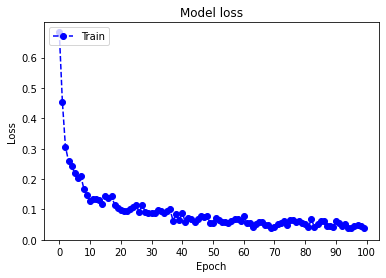

In [25]:
plt.plot(trained.history['loss'],'bo--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,0.7,0.1))
plt.show()

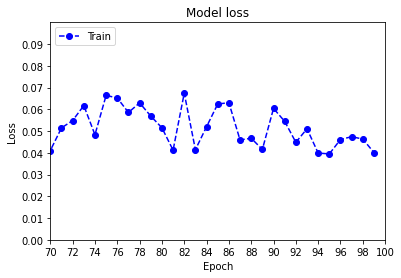

In [33]:
plt.plot(trained.history['loss'],'bo--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xlim(70,100)
plt.ylim(0,0.1)
plt.xticks(np.arange(70,101,2))
plt.yticks(np.arange(0,0.1,0.01))
plt.show()

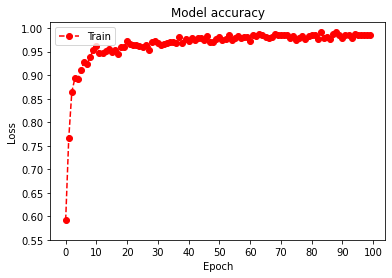

In [26]:
plt.plot(trained.history['accuracy'],'ro--')
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0.55,1.01,0.05))
plt.show()

In [34]:
import pickle

f=open("/content/drive/MyDrive/models/siamese_quarters/trained_loss.obj",'wb')


pickle.dump(trained.history['loss'],f)


In [35]:
f=open("/content/drive/MyDrive/models/siamese_quarters/trained_accuracy.obj",'wb')


pickle.dump(trained.history['accuracy'],f)


In [11]:
# load model after session crashed

import_path_keras='/content/drive/MyDrive/models/siamese_quarters/1608316269.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[0][0]         

In [12]:
def one_shot_task(X_valid1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_valid1





  for i in range(n_classes):

   
     # this part was rewritten to optimize speed:


     # generate an array of indices of the elements from the same class as element idx1
     indices = [j for j, y in enumerate(y_train) if y == i]
      
     # and get a random element from this array
     idx2 = indices[ np.random.randint(0,len(indices))]

     pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [13]:
def test_accuracy(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(X_valid[i],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



In [14]:
# enable garbage collector: RAM full, environment crashes when trying to run accuracy on test set

import gc
gc.enable()

In [39]:
# accuracy on validation data set

tic=time.time()

test_accuracy(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 10 accuracy: 100.0
step: 20 accuracy: 100.0
step: 30 accuracy: 100.0
step: 40 accuracy: 97.5609756097561
step: 50 accuracy: 96.07843137254902
step: 60 accuracy: 93.44262295081967
step: 70 accuracy: 91.54929577464789
step: 90 accuracy: 87.91208791208791
step: 100 accuracy: 89.10891089108911
step: 120 accuracy: 89.25619834710744
step: 130 accuracy: 88.54961832061069
step: 140 accuracy: 88.65248226950355
step: 150 accuracy: 89.40397350993378
step: 170 accuracy: 90.05847953216374
step: 180 accuracy: 90.05524861878453
step: 187 accuracy: 90.37433155080214
104.33834552764893 s


In [15]:
def test_accuracy_augment(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(data_augmentation.flow(X_valid[i:i+1])[0][0],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:', accuracy)

  return accuracy

In [16]:
# test accuracy applying data augmentation on validation dataset
tic=time.time()

test_accuracy_augment(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 10 accuracy: 90.9090909090909
step: 20 accuracy: 90.47619047619048
step: 30 accuracy: 93.54838709677419
step: 40 accuracy: 92.6829268292683
step: 50 accuracy: 88.23529411764706
step: 60 accuracy: 86.88524590163935
step: 70 accuracy: 88.73239436619718
step: 100 accuracy: 88.11881188118812
step: 110 accuracy: 89.1891891891892
step: 130 accuracy: 88.54961832061069
step: 150 accuracy: 88.74172185430463
step: 170 accuracy: 88.30409356725146
step: 180 accuracy: 88.95027624309392
step: 187 accuracy: 89.3048128342246
107.26797032356262 s


True label: US.Quarter.2000.New Hampshire.Reverse
Predicted label: US.Quarter.2000.New Hampshire.Reverse


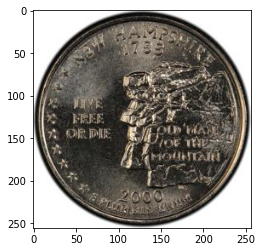

In [22]:
# get random image from validation dataset

i1=np.random.randint(0,len(X_valid))

X_valid1=X_valid[i1]
y_valid1=y_valid[i1]


# show image

plt.imshow(X_valid1)


# true label:

dict1 = valid_generator.class_indices
inv_dict1 = {v: k for k, v in dict1.items()}

true_label = inv_dict1[y_valid1]


# predicted label

y_pred = np.argmax( model.predict(one_shot_task(X_valid1,X_train,y_train)) )

dict2 = train_generator.class_indices
inv_dict2 = {v: k for k, v in dict2.items()}

pred_label = inv_dict1[y_pred]




print("True label:", true_label)
print("Predicted label:", pred_label)

True label: US.Quarter.2002.Indiana.Reverse
Predicted label: US.Quarter.2002.Indiana.Reverse


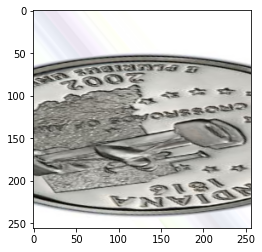

In [36]:
# get random validation image, use data augmentation

i1=np.random.randint(0,len(X_valid))

X_valid1=data_augmentation.flow(X_valid[i1:i1+1])[0][0]
y_valid1=y_valid[i1]


# show image

plt.imshow(X_valid1)


# true label:

dict1 = valid_generator.class_indices
inv_dict1 = {v: k for k, v in dict1.items()}

true_label = inv_dict1[y_valid1]


# predicted label

y_pred = np.argmax( model.predict(one_shot_task(X_valid1,X_train,y_train)) )

dict2 = train_generator.class_indices
inv_dict2 = {v: k for k, v in dict2.items()}

pred_label = inv_dict1[y_pred]




print("True label:", true_label)
print("Predicted label:", pred_label)